More and more business owners, especially restaurants are paying close attension to their business reviews on Yelp from different customers. The more reviews on Yelp, it is more likely to attract more customers and increase the revenue. Yelp typically has two component of the reviews, one is the star rating of 1-5, the other is the review comments. However, many restaurants have a lot of reviews. Simply looked at the star ratings for the particular restaurant does not give us what were the customers' experience. In addition, the business review stars is an aggregate values of thoundsounds of reivewers' star ratings. Therefore, it is necessary to review the text comments. In this notebook, I will first to do some basic data exploration of the yelp dataset. Then I will apply the sentiment analysis on the review comments and develope two predictive models based on the review comments, predict the star ratings for the individual customers and predict the continuity of business. 
<br>
<br>
Data Description <br>
The data obtained from Kaggle, including the following files
1. business.csv  List of business_id, business_name, address, categories
2. checkin.csv   Number of check in for different business in different hours
3. review.csv    Main text comments reviews including business_id, text, star_rating, is_open/close 

Link to the data:
https://www.kaggle.com/yelp-dataset/yelp-dataset/version/6

# Importing data and packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import statsmodels.api as sm 

#Set up all the columns to display
pd.set_option('display.max_columns',None)

import warnings
warnings.filterwarnings('ignore')


from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


#import different nlp packages
import nltk
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re

In [2]:
# Import files
business = pd.read_csv('~/yelp/business.csv')
checkin = pd.read_csv('~/yelp/checkin.csv')
review = pd.read_csv('~/yelp/review.csv')


In [12]:
#Sanity Check
display(business.head())
display(checkin.head())
display(review.head())

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",NaN,"""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...


,business_id,weekday,hour,checkins
0,3Mc-LxcqeguOXOVT_2ZtCg,Tue,0:00,12
1,SVFx6_epO22bZTZnKwlX7g,Wed,0:00,4
2,vW9aLivd4-IorAfStzsHww,Tue,14:00,1
3,tEzxhauTQddACyqdJ0OPEQ,Fri,19:00,1
4,CEyZU32P-vtMhgqRCaXzMA,Tue,17:00,1


,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


# Data Cleaning

Data cleaning is crucial text analyzing. Below is the data cleaning steps I performed. 

Review 
1. Change the data type from string to data formate in the date column of the review file.
2. In order to save some computing power, my analysis will be focus on the review from 2015 to 2017. Subset the 2015-2017 reviews from the original review files.

Business 
1. The yelp data contains many different categories of business. Since I am only interested in restaurants, I will filter out the food and restaurant categories from the categories column
2. The business files contains different business around the world. For my analysis purpose, I am only interested in North America business. Therefore, I have filtered out the North America restaurants based on the North America state/province abbreviation. 
3. After filter out the business files, subset the review files based on the business_id in the business files. 

Check in <br>
Aggregate the total number of check ins based on bussiness id. 

Other Data Cleaning <br>
For my analysis, review comments will be the major part. Therefore, it will required cleaned text. I performed the following steps to clean the review comments:
1. Tokenized the review comments at word level
2. Change all upper case to lower case
3. Remove regular English Stopwords based on the English stopwords packages in NLTK
4. Remove punctuations and other symbols/ words less than 2 characters
5. Untokenzied the word and returned a cleaned text column in the dataframe
6. Later I found there are foreign langues hidden in the review comments, so first I applied the languagedetect package to detect non-english review comments and remove them. However, some of the review comments are combined with English and foreign languages, and the language detect package have been treated those as english. Therefore, I used regex to retains only the english portion of the reviews. 



## Cleaning data for review files


In [13]:
# change date from object to date time
review['date'] = pd.to_datetime(review['date'], format = '%Y-%m-%d')

#sanity check
review['date'][0]

Timestamp('2016-05-28 00:00:00')

In [14]:
#check how many reviews in each year
pd.DatetimeIndex(review['date']).year.value_counts()

2017    1128518
2016    1052916
2015     911487
2014     678351
2013     472595
2012     350381
2011     290933
2010     187073
2009      98288
2008      61553
2007      23020
2006       5669
2005        870
2004         14
Name: date, dtype: int64

In [15]:
#select only reviews after 2015
review1 = review[(review['date']>="2015")]

In [16]:
#check on how many reviews in 2015, 2016, and 2017
pd.DatetimeIndex(review1['date']).year.value_counts()

2017    1128518
2016    1052916
2015     911487
Name: date, dtype: int64

In [21]:
#eliminate the not used last three columns
review1 = review1.iloc[:,:-3]
review1.head()

,review_id,user_id,business_id,stars,date,text
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...


In [22]:
# check on missing values
review1.isnull().sum()

review_id      0
user_id        0
business_id    0
stars          0
date           0
text           0
dtype: int64

## Cleaning data for business files. 


Steps Completed: 
    - Filter out food and restaurant category
    - Filter out north america by state abbv
    - select review1 with only north amercia restaurant from previous steps by business id
      


In [23]:
#filter only restuant and food from all business

business_filter = business[(business['categories'].str.contains("Food",regex=True))|
         (business['categories'].str.contains("Restaurant",regex=True))]

#sanity check
display(business.shape)
display(business_filter.shape)

(174567, 13)

(69079, 13)

In [24]:
#filter out North America Only
#check on different locations for the business
business_filter['state'].value_counts()

ON     16845
AZ     13826
NV      9263
OH      6031
QC      5941
NC      4969
PA      4686
BW      2023
WI      1984
EDH     1906
IL       786
SC       291
MLN      120
HLD       76
CHE       75
NYK       71
FIF       34
ELN       32
C         22
WLN       21
NY        12
NI        10
01        10
ST         8
VS         6
ESX        4
BY         3
IN         3
CO         2
GLG        2
XGL        2
6          1
30         1
CA         1
WHT        1
AK         1
VA         1
RCC        1
ABE        1
3          1
PKN        1
KHL        1
B          1
HU         1
FLN        1
ZET        1
Name: state, dtype: int64

In [25]:
#get only US and canada business

#set up list contains only north america state
state_abbv = pd.read_csv('gs://mybucket_terrancexia/Yelp/state_abbr.csv')

#get north amercia business only from business_filter
business_nora = business_filter[business_filter['state'].isin(state_abbv['Code'])]

state_count = business_nora['state'].value_counts()


In [26]:
# Select north america reviews only based on business_nora['business_id']
review_nora = review1[review1['business_id'].isin(business_nora['business_id'])]

display(review_nora.shape)
display(review1.shape)

(2027121, 6)

(3092921, 6)

In [29]:
review_nora.head()

,review_id,user_id,business_id,stars,date,text
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...


<Figure size 1440x720 with 0 Axes>

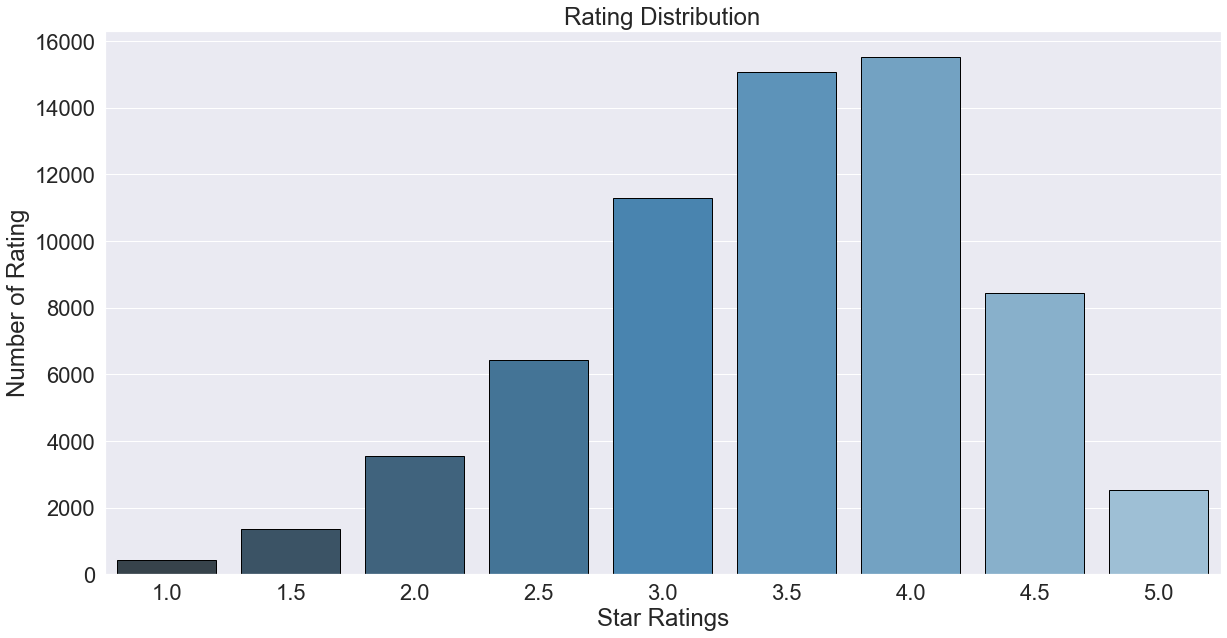

In [18]:
#plot out number of stars distribution 
sns.set(font_scale=15)
sns.set(style = 'darkgrid')
plt.figure(figsize=(20,10))
sns.set(font_scale=2.0)
plt.figure(figsize=(20,10))
sns.countplot(number_reviews['stars'], edgecolor='black', palette = 'Blues_d')
plt.title('Rating Distribution')
plt.ylabel('Number of Rating')
plt.xlabel('Star Ratings')

plt.show()

## Clean Text review in review_nora

Steps Completed:

    1. Tokenized the text
    2. Change to lower character for each tokens
    3. Remove stopwords 
    4. Remove punctuation 
    5. Untokenized the text 
    6. Unlist each row from list of strings to strings


In [31]:
#import different nlp packages
import nltk
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re

In [32]:
#define function to remove stop words
def remove_stopwords(list_of_tokens):
    '''
    Remove English Stop Words
    '''
    
    cleaned_tokens = []
    for token in list_of_tokens:
        if token in ENGLISH_STOP_WORDS: continue
        cleaned_tokens.append(token)
        
    return cleaned_tokens

In [33]:
#define function to remove punctuation, character less than 2, remove extra''
def remove_punctuation(list_of_tokens):
    '''
    1. Remove Punctuation
    2. Remove character less than 2
    3. Remove extra '' in the list
    
    '''
    cleaned_tokens = []
    for word in list_of_tokens:
          
        #remove punctuation
        for punctuation in string.punctuation:
            word = word.replace(punctuation,'')
            
            #remove character less than 2
            word = re.sub(r'\b\w{1,2}\b', '', word)
            
        #append the word to cleaned token
        cleaned_tokens.append(word)
        
        #remove extra '' in the list
        while('' in cleaned_tokens):
            cleaned_tokens.remove('')
            
    return cleaned_tokens

In [34]:
#define a function to untokenlize the tokens
def the_untokenizer(token_list):
    '''
    Untokenize the token back to string
    '''
    return " ".join(token_list)

In [35]:
#define a function to cleaning_out_texts to combine functions:tokenize, remove_stopwords, remove_punctuation, the_untokenizer

def cleaning_out_texts(text):
    '''
    1. Tokenized the text
    2. Change to lower character for each tokens
    3. Apply remove_stopwords function defined above
    4. Apply remove_punctuation function defined above
    5. Apply the_untokenizer function defined above
    6. Returned cleaned text
    
    '''
    cleaned_text = []
    
    tokenizer_list = word_tokenize(text)
    
    lower_word = []
    for word in tokenizer_list:
        
        word = word.lower()
        
        lower_word.append(word)
    
    removed_stopwords_list = remove_stopwords(lower_word)
        
    removed_punctuation_list = remove_punctuation(removed_stopwords_list)
                
    back_to_string = the_untokenizer(removed_punctuation_list)
        
    cleaned_text.append(back_to_string)
        
    return cleaned_text       

In [39]:
review_nora['cleaned_text']= review_nora['text'].apply(cleaning_out_texts)
review_nora.head()

,review_id,user_id,business_id,stars,date,text,cleaned_text
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,[super simple place amazing nonetheless serve ...
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,[small unassuming place changes menu cool deco...
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,[lester located beautiful neighborhood 1951 kn...
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,[love coming yes place needs floor swept peanu...
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,[chocolate almond croissant amazing light butt...


In [40]:
# define a function to remove extra '' and unpack the list

def unlist(list):
    return str(list).strip("[],''")

In [42]:
#apply the unlist function to cleaned_text
review_nora['cleaned_text']=review_nora['cleaned_text'].apply(unlist)

In [43]:
#Sanity check
review_nora['cleaned_text'].head()

0    super simple place amazing nonetheless serve t...
1    small unassuming place changes menu cool decor...
2    lester located beautiful neighborhood 1951 kno...
3    love coming yes place needs floor swept peanut...
4    chocolate almond croissant amazing light butte...
Name: cleaned_text, dtype: object

In [49]:
#Reset index for review_nora

review_nora = review_nora.reset_index(drop=True)
display(review_nora.head())
review_nora.index

,review_id,user_id,business_id,stars,date,text,cleaned_text
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,super simple place amazing nonetheless serve t...
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,small unassuming place changes menu cool decor...
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,lester located beautiful neighborhood 1951 kno...
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,love coming yes place needs floor swept peanut...
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,chocolate almond croissant amazing light butte...


RangeIndex(start=0, stop=2027121, step=1)

## Clean checkin files

Steps Completed:

    1. Aggregate number of checkins by business id 
    

In [51]:
checkin.head()

,business_id,weekday,hour,checkins
0,3Mc-LxcqeguOXOVT_2ZtCg,Tue,0:00,12
1,SVFx6_epO22bZTZnKwlX7g,Wed,0:00,4
2,vW9aLivd4-IorAfStzsHww,Tue,14:00,1
3,tEzxhauTQddACyqdJ0OPEQ,Fri,19:00,1
4,CEyZU32P-vtMhgqRCaXzMA,Tue,17:00,1


In [53]:
#aggregate the number of checkins by business_id
aggregate_checkins = checkin.groupby('business_id').agg({'checkins':['sum']}).reset_index()
aggregate_checkins.columns =['business_id','num_checkins']
aggregate_checkins.head()

,business_id,num_checkins
0,--6MefnULPED_I942VcFNA,139
1,--7zmmkVg-IMGaXbuVd0SQ,153
2,--8LPVSo5i0Oo61X01sV9A,1
3,--9QQLMTbFzLJ_oT-ON3Xw,33
4,--9e1ONYQuAa-CB_Rrw7Tw,2568


# Convert Words to Numbers

Feature Engingeering 
1. Applying TextBlob packages to get the polarity and subjective score for each review and append to the dataframe
2. Applying sentiment packages from VADER to get the netural, negative, and positive ratings for each reviews and append to dataframe
3. Get the length of the review comments for each row and append to the dataframe
4. Append the number of check in, whether the business is open from the business file based on the business id



In [56]:
#Using Textblob to get polarity and subjectivity by sentence
from textblob import TextBlob

polarity = []
subjectivity = []

for n in range(review_nora.shape[0]):
    
    polar_score = TextBlob(review_nora['cleaned_text'][n]).sentiment[0]
    subject_score = TextBlob(review_nora['cleaned_text'][n]).sentiment[1]
    
    polarity.append(polar_score)
    subjectivity.append(subject_score)

review_nora['polarity']=polarity
review_nora['subjectivity']=subjectivity

In [57]:
#sanity check
review_nora.head(2)

,review_id,user_id,business_id,stars,date,text,cleaned_text,polarity,subjectivity
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,super simple place amazing nonetheless serve t...,0.327083,0.605952
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,small unassuming place changes menu cool decor...,0.342857,0.571429


### Get the length of each review


In [59]:
# getting the length of words for each row
review_length = []

for n in range(review_nora.shape[0]):
    
    length = len(review_nora['cleaned_text'][n].split())
    
    review_length.append(length)
    

#sanity check 
display(review_nora.shape)
display(len(review_length))
    

(2027121, 9)

2027121

In [60]:
# Append the review_length to the review_nora_cleaned df
review_nora['review_length']= review_length

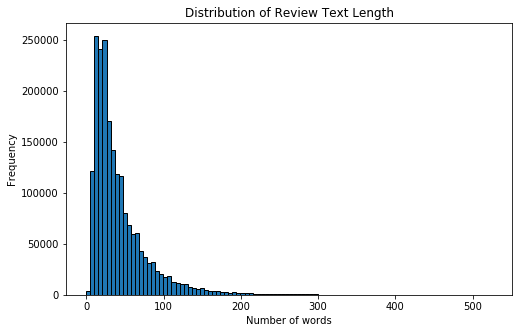

In [61]:
# Visualize the distribution of review_length

plt.figure(figsize=(8,5))
plt.hist(review_length, edgecolor='black', bins =100)
plt.title('Distribution of Review Text Length')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.show()

### Change the text to sentiment using vader package


VADER Sentiment Analysis
VADER is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. VADER uses a combination of A sentiment lexicon is a list of lexical features (e.g., words) which are generally labelled according to their semantic orientation as either positive or negative.

The Positive, Negative and Neutral scores represent the proportion of text that falls in these categories. This means our sentence was rated as 67% Positive, 33% Neutral and 0% Negative. Hence all these should add up to 1.
The Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive). 


compound score metric
positive sentiment: compound score >= 0.05
neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
negative sentiment: compound score <= -0.05

In [62]:
#import vader packages
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [63]:
# getting sentiment ratings from the text reviews and append each row as dictionary in the list l1
l1=[]
for j in range(review_nora.shape[0]):
    l1.append(analyser.polarity_scores(review_nora['cleaned_text'][j]))



In [64]:
# Sanity check on l1
len(l1)

2027121

In [65]:
#change l1 to df and append to original review_nora_cleaned df

l1_df=pd.DataFrame(l1, index= range(len(l1)))

review_nora[['negative','neutral','positive','compound_score']]= l1_df

In [66]:
#Sanity check
review_nora.head(2)

,review_id,user_id,business_id,stars,date,text,cleaned_text,polarity,subjectivity,review_length,negative,neutral,positive,compound_score
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,super simple place amazing nonetheless serve t...,0.327083,0.605952,15,0.0,0.445,0.555,0.9287
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,small unassuming place changes menu cool decor...,0.342857,0.571429,41,0.0,0.802,0.198,0.8542


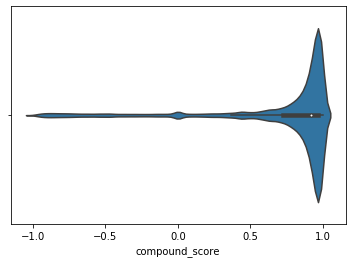

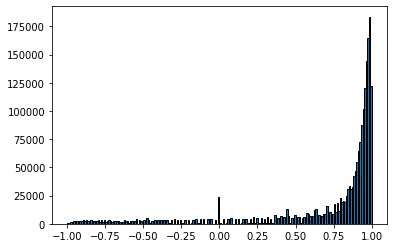

In [67]:
# Explore the distribution of compound_score before grouping to Positive, Negative, and Netural

#violin plot for the commond_score
plt.figure()
sns.violinplot(review_nora['compound_score'])
plt.show()

#histogram of the compound_score
plt.figure()
plt.hist(review_nora['compound_score'], edgecolor='black', bins=200)
plt.show()

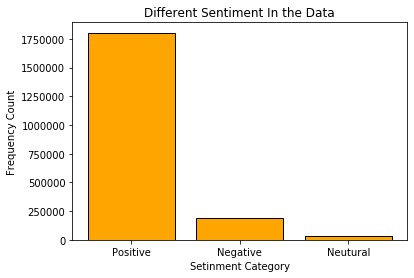

In [68]:
# get value count for positive, netural, and negative reviews in the data

pos = (review_nora['compound_score']>=0.05).sum()
neg = (review_nora['compound_score']<=-0.05).sum()
neu = ((review_nora['compound_score']>-0.05) & (review_nora['compound_score']<0.05)).sum()

sentiment = ['Positive','Negative','Neutural']
count =[pos, neg, neu]
plt.figure()
plt.bar(sentiment, count,edgecolor = 'black', color='orange')
plt.title('Different Sentiment In the Data')
plt.xlabel('Setinment Category')
plt.ylabel('Frequency Count')
plt.show()

# Combining Different Dataframe

## Create new df by combining different data


Combined review_nora, aggregate_checkins, business_name, is_open from business to one single files: df

In [70]:
#check on review_nora head
review_nora.head(2)

,review_id,user_id,business_id,stars,date,text,cleaned_text,polarity,subjectivity,review_length,negative,neutral,positive,compound_score
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,super simple place amazing nonetheless serve t...,0.327083,0.605952,15,0.0,0.445,0.555,0.9287
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,small unassuming place changes menu cool decor...,0.342857,0.571429,41,0.0,0.802,0.198,0.8542


In [71]:
#subset business_id, name, review count, is_open, stars from business files
business_subset = business[['business_id','name', 'review_count', 'is_open','stars']]
business_subset.head(2)

,business_id,name,review_count,is_open,stars
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",22,1,4.0
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",11,1,3.0


In [72]:
#remove "" in the name column for busines_subset
business_subset['name']= business_subset['name'].apply(lambda x : x.replace('"',''))

business_subset.head(2)

,business_id,name,review_count,is_open,stars
0,FYWN1wneV18bWNgQjJ2GNg,Dental by Design,22,1,4.0
1,He-G7vWjzVUysIKrfNbPUQ,Stephen Szabo Salon,11,1,3.0


In [73]:
#check on aggregagte_checkins
aggregate_checkins.head(2)

,business_id,num_checkins
0,--6MefnULPED_I942VcFNA,139
1,--7zmmkVg-IMGaXbuVd0SQ,153


In [74]:
# merge review_nora_cleaned with business_subset
df = pd.merge(review_nora, business_subset, on = 'business_id', how='left')

In [75]:
# merge df with aggregate_checkins
df = pd.merge(df, aggregate_checkins, on = 'business_id', how='left')

#sanity check
df.head()

,review_id,user_id,business_id,stars_x,date,text,cleaned_text,polarity,subjectivity,review_length,negative,neutral,positive,compound_score,name,review_count,is_open,stars_y,num_checkins
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,super simple place amazing nonetheless serve t...,0.327083,0.605952,15,0.000,0.445,0.555,0.9287,Wilensky's,84,1,4.0,119.0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,small unassuming place changes menu cool decor...,0.342857,0.571429,41,0.000,0.802,0.198,0.8542,Tuck Shop,50,1,4.5,62.0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,lester located beautiful neighborhood 1951 kno...,0.425000,0.525000,24,0.000,0.855,0.145,0.5994,Lester's Deli,70,1,4.0,72.0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,love coming yes place needs floor swept peanut...,0.070000,0.495385,44,0.053,0.716,0.231,0.8658,Five Guys,61,1,3.5,89.0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,chocolate almond croissant amazing light butte...,0.500000,0.700000,17,0.000,0.667,0.333,0.8176,Maison Christian Faure,397,1,4.5,755.0


In [78]:
# Get names of columns
df.columns

Index(['review_id', 'user_id', 'business_id', 'star_individual', 'date',
       'text', 'cleaned_text', 'polarity', 'subjectivity', 'review_length',
       'negative', 'neutral', 'positive', 'compound_score', 'name',
       'review_count', 'is_open', 'business_stars', 'num_checkins'],
      dtype='object')

In [77]:
#rename the columns
df.columns=['review_id',           'user_id',       'business_id', \
            'star_individual',        'date',              'text', \
            'cleaned_text',          'polarity',      'subjectivity', \
           'review_length',          'negative',           'neutral', \
                'positive',    'compound_score',              'name', \
            'review_count',           'is_open',           'business_stars', \
           'num_checkins']

In [37]:
# check on missing values
df.isnull().sum()

review_id             0
user_id               0
business_id           0
star_individual       0
date                  0
text                  0
cleaned_text         16
polarity              0
subjectivity          0
review_length         0
negative              0
neutral               0
positive              0
compound_score        0
name                  0
review_count          0
is_open               0
business_stars        0
num_checkins       5736
dtype: int64

In [44]:
#check on describe stats for num_checkins
df['num_checkins'].describe().apply(lambda x: format(x, 'f'))

count    2021385.000000
mean        1275.963367
std         2800.091761
min            1.000000
25%          116.000000
50%          394.000000
75%         1199.000000
max        32393.000000
Name: num_checkins, dtype: object

In [45]:
# Replace num_checkins for missing as 0. In the data not every restaurants have check ins. Therefore, replace with 0 for nan
df['num_checkins'] = np.where(df['num_checkins'].isnull(),0, df['num_checkins'])
df['num_checkins'].describe().apply(lambda x: format(x, 'f'))

count    2027121.000000
mean        1272.352864
std         2796.948686
min            0.000000
25%          114.000000
50%          391.000000
75%         1191.000000
max        32393.000000
Name: num_checkins, dtype: object

In [47]:
# drop the 16 missing values for cleaned text

df = df.dropna(axis=0).reset_index(drop=True)

#sanity check
display(df.shape)
df.isnull().sum()

(2027105, 19)

review_id          0
user_id            0
business_id        0
star_individual    0
date               0
text               0
cleaned_text       0
polarity           0
subjectivity       0
review_length      0
negative           0
neutral            0
positive           0
compound_score     0
name               0
review_count       0
is_open            0
business_stars     0
num_checkins       0
dtype: int64

## Eliminate foreign language in the review

In [50]:
#sanity check
df.head()

,Unnamed: 0,review_id,user_id,business_id,star_individual,date,text,cleaned_text,polarity,subjectivity,review_length,negative,neutral,positive,compound_score,name,review_count,is_open,business_stars,num_checkins,language
0,0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,super simple place amazing nonetheless serve t...,0.327083,0.605952,15,0.000,0.445,0.555,0.9287,Wilensky's,84,1,4.0,119.0,en
1,1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,small unassuming place changes menu cool decor...,0.342857,0.571429,41,0.000,0.802,0.198,0.8542,Tuck Shop,50,1,4.5,62.0,en
2,2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,lester located beautiful neighborhood 1951 kno...,0.425000,0.525000,24,0.000,0.855,0.145,0.5994,Lester's Deli,70,1,4.0,72.0,en
3,3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,love coming yes place needs floor swept peanut...,0.070000,0.495385,44,0.053,0.716,0.231,0.8658,Five Guys,61,1,3.5,89.0,en
4,4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,chocolate almond croissant amazing light butte...,0.500000,0.700000,17,0.000,0.667,0.333,0.8176,Maison Christian Faure,397,1,4.5,755.0,en


In [12]:
# using language detect to find what language is the text
from langdetect import detect
a = df['text']
language_list =[]
for n in a.index:
    language_list.append(detect(a[n]))

In [13]:
#check on the different unique values in the language list
np.unique(language_list, return_counts=True)

(array(['af', 'ca', 'cs', 'cy', 'da', 'de', 'en', 'es', 'et', 'fi', 'fr',
        'hr', 'hu', 'id', 'it', 'ja', 'ko', 'lt', 'nl', 'no', 'pl', 'pt',
        'ro', 'sk', 'sl', 'so', 'sq', 'sv', 'sw', 'tl', 'tr', 'vi',
        'zh-cn', 'zh-tw'], dtype='<U5'),
 array([     43,      37,       3,      20,      32,     388, 2013544,
           1100,      16,       4,   10674,       5,       1,      12,
            135,     300,     116,       1,      66,      30,       6,
             93,      16,       5,       3,      22,       1,      32,
              1,      13,      24,       3,     239,     120]))

In [14]:
# add language to df

df['language'] = language_list
df.head()

,review_id,user_id,business_id,star_individual,date,text,cleaned_text,polarity,subjectivity,review_length,negative,neutral,positive,compound_score,name,review_count,is_open,business_stars,num_checkins,language
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,super simple place amazing nonetheless serve t...,0.327083,0.605952,15,0.000,0.445,0.555,0.9287,Wilensky's,84,1,4.0,119.0,en
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,small unassuming place changes menu cool decor...,0.342857,0.571429,41,0.000,0.802,0.198,0.8542,Tuck Shop,50,1,4.5,62.0,en
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,lester located beautiful neighborhood 1951 kno...,0.425000,0.525000,24,0.000,0.855,0.145,0.5994,Lester's Deli,70,1,4.0,72.0,en
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,love coming yes place needs floor swept peanut...,0.070000,0.495385,44,0.053,0.716,0.231,0.8658,Five Guys,61,1,3.5,89.0,en
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,chocolate almond croissant amazing light butte...,0.500000,0.700000,17,0.000,0.667,0.333,0.8176,Maison Christian Faure,397,1,4.5,755.0,en


In [16]:
# only use English language review comments
df1 = df[df['language']=='en']
df1.shape

(2013544, 20)

In [37]:
#count number of English Record
df1['language'].value_counts()

en    2013544
Name: language, dtype: int64

## Continue to Remove non-english character

In [130]:
# checking sample text with mixed language
display(df['cleaned_text'][829118])
type(df['cleaned_text'][829118])

'皆さん、こんいちわ。 ぼくわおすかです。 start things place got giant window door broadcasting league legends right entire place filled tvs playing league related videos tables labled number league legend champion pretty cool snacks come raw skewer mini conveyer belt rotates skewer cooks meat kinda like kbbq cept skewer ayce price person avg depending eat wouldnt say pricey unique like variety food choices snacks example clamshells mussles beeflamb kabobs skewers fried potatoe chips pretty taiwanese snacks expect chinese night market taste asianight claims free wifi kinda disappears seconds soo idk lol overall good'

str

In [134]:
#Filter out the mixed english and other languages 
#apply Regex to remove non english characters in each of the reviews
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub('[^a-zA-Z0-9\s]','', x).strip() )


'start things place got giant window door broadcasting league legends right entire place filled tvs playing league related videos tables labled number league legend champion pretty cool snacks come raw skewer mini conveyer belt rotates skewer cooks meat kinda like kbbq cept skewer ayce price person avg depending eat wouldnt say pricey unique like variety food choices snacks example clamshells mussles beeflamb kabobs skewers fried potatoe chips pretty taiwanese snacks expect chinese night market taste asianight claims free wifi kinda disappears seconds soo idk lol overall good'

In [164]:
#sanity check
df.head()

,review_id,user_id,business_id,star_individual,date,text,cleaned_text,polarity,subjectivity,review_length,negative,neutral,positive,compound_score,name,review_count,is_open,business_stars,num_checkins,language
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,super simple place amazing nonetheless serve t...,0.327083,0.605952,15,0.000,0.445,0.555,0.9287,Wilensky's,84,1,4.0,119.0,en
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,small unassuming place changes menu cool decor...,0.342857,0.571429,41,0.000,0.802,0.198,0.8542,Tuck Shop,50,1,4.5,62.0,en
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,lester located beautiful neighborhood 1951 kno...,0.425000,0.525000,24,0.000,0.855,0.145,0.5994,Lester's Deli,70,1,4.0,72.0,en
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,love coming yes place needs floor swept peanut...,0.070000,0.495385,44,0.053,0.716,0.231,0.8658,Five Guys,61,1,3.5,89.0,en
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,chocolate almond croissant amazing light butte...,0.500000,0.700000,17,0.000,0.667,0.333,0.8176,Maison Christian Faure,397,1,4.5,755.0,en


# Get the word cloud for each of the star ratings

From the review comments, I want to see what are people talking about for star 1 rating restaurant vs star 5 rating restaurant. Using the word cloud we can see the most frequent words that have been mentioned in the review comments. 

Steps completed:

    1. Parse out each star ratings with its related cleaned text
    2. Word Cloud for each ratings. 

In [8]:
# Separate the stars and the text based on the ratings, change the pd series to list
star_5 = pd.DataFrame(df[df['star_individual']==5]).reset_index(drop=True)
star_4 = pd.DataFrame(df[df['star_individual']==4]).reset_index(drop=True)
star_3 = pd.DataFrame(df[df['star_individual']==3]).reset_index(drop=True)
star_2 = pd.DataFrame(df[df['star_individual']==2]).reset_index(drop=True)
star_1 = pd.DataFrame(df[df['star_individual']==1]).reset_index(drop=True)

In [11]:
#Display shape for each dataframe
display(star_5.shape)
display(star_4.shape)
display(star_3.shape)
display(star_2.shape)
display(star_1.shape)

(862727, 20)

(472769, 20)

(240588, 20)

(179199, 20)

(258261, 20)

In [79]:
# Get a sample of approximate 20% of original data for creating wordcloud 
star_5_sample=star_5.sample(175000).reset_index(drop=True)
star_4_sample=star_4.sample(95000).reset_index(drop=True)
star_3_sample=star_3.sample(50000).reset_index(drop=True)
star_2_sample=star_2.sample(36000).reset_index(drop=True)
star_1_sample=star_1.sample(52500).reset_index(drop=True)

In [14]:
#Display shape for each sample dataframe
display(star_5_sample.shape)
display(star_4_sample.shape)
display(star_3_sample.shape)
display(star_2_sample.shape)
display(star_1_sample.shape)

(175000, 20)

(95000, 20)

(50000, 20)

(36000, 20)

(52000, 20)

In [80]:
#Transform the cleaned_text from columns to text
text_5 = ' '.join(cleaned_text for cleaned_text in star_5_sample['cleaned_text'])
text_4 = ' '.join(cleaned_text for cleaned_text in star_4_sample['cleaned_text'])
text_3 = ' '.join(cleaned_text for cleaned_text in star_3_sample['cleaned_text'])
text_2 = ' '.join(cleaned_text for cleaned_text in star_2_sample['cleaned_text'])
text_1 = ' '.join(cleaned_text for cleaned_text in star_1_sample['cleaned_text'])

#Sanity check
display(type(text_5))
display(type(text_4))
display(type(text_3))
display(type(text_2))
display(type(text_1))

str

str

str

str

str

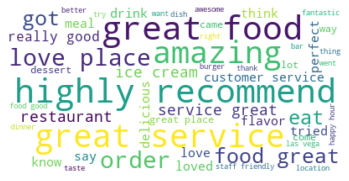

In [18]:
from wordcloud import WordCloud
# wordcloud for star_5 
cloud = WordCloud(background_color="white", max_words=50, max_font_size=50).generate(text_5)
plt.figure()
plt.imshow(cloud, interpolation ='bilinear')
plt.axis('off')
plt.show()

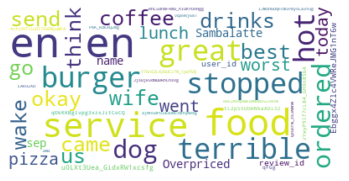

In [19]:
# wordcloud for star_1
cloud4 = WordCloud(background_color="white", max_words=50, max_font_size=50).generate(str(star_1))
plt.figure()
plt.imshow(cloud4, interpolation ='bilinear')
plt.axis('off')
plt.show()

In [13]:
# Update stopwords to make the wordcloud more obviuos. 
stopwords = set(STOPWORDS)
stopwords.update(['food', 'coffee', 'ice cream','hot dog','burger','pizza','eat','think','restaurant','thing','sure','said',\
                 'stopped','today','dog','ice','cream','lot','come','meal','order','dessert','tried','say','know','came',\
                  'ordered','got','want','menu','meat','dogs','burgers','right', 'make','guy','going','let','told','tell',\
                  'day', 'really','friend','look','looked','way','gave','check','salad','plate','husband','wife','instead',\
                  'asked','actually','wanted','place','went','ask','called','good','eating','item thought','love','loved',\
                  'try','definitely','home','people','thank','things','las vega','dishes','table','drink','lunch'
                 ])

### Testing word cloud to update stopwords

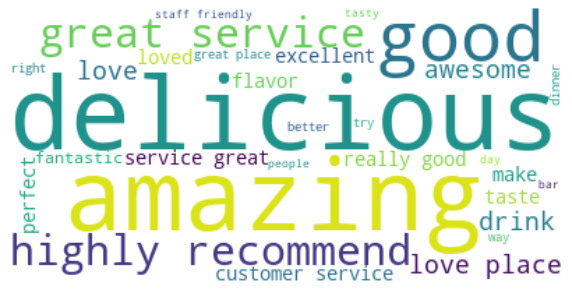

In [41]:
# wordcloud for star_5 
cloud = WordCloud(stopwords=stopwords, background_color="white", max_words=30).generate(text_5)
plt.figure(figsize=(10,10))
plt.imshow(cloud, interpolation ='bilinear')
plt.axis('off')
plt.show()

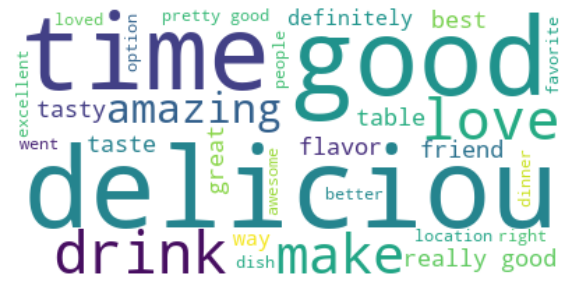

In [42]:
# wordcloud for star_4
cloud1 = WordCloud(stopwords=stopwords, background_color="white", max_words=30).generate(text_4)
plt.figure(figsize=(10,10))
plt.imshow(cloud1, interpolation ='bilinear')
plt.axis('off')
plt.show()

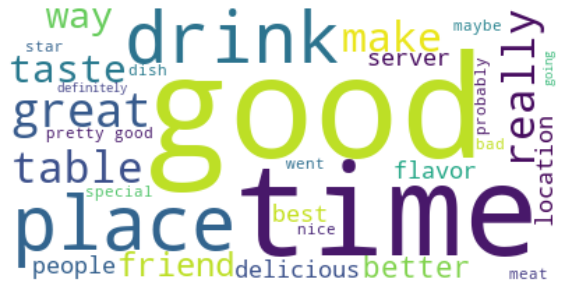

In [43]:
# wordcloud for star_3
cloud2 = WordCloud(stopwords=stopwords, background_color="white", max_words=30).generate(text_3)
plt.figure(figsize=(10,10))
plt.imshow(cloud2, interpolation ='bilinear')
plt.axis('off')
plt.show()

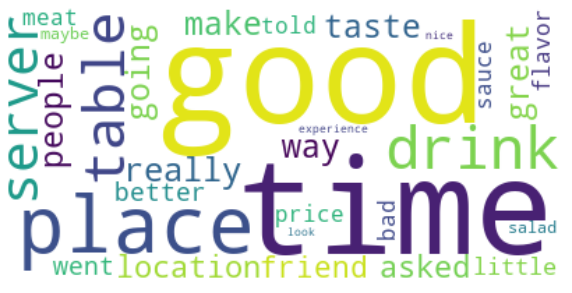

In [44]:
# wordcloud for star_2
cloud3 = WordCloud(stopwords = stopwords, background_color="white", max_words=30).generate(text_2)
plt.figure(figsize=(10,10))
plt.imshow(cloud3, interpolation ='bilinear')
plt.axis('off')
plt.show()

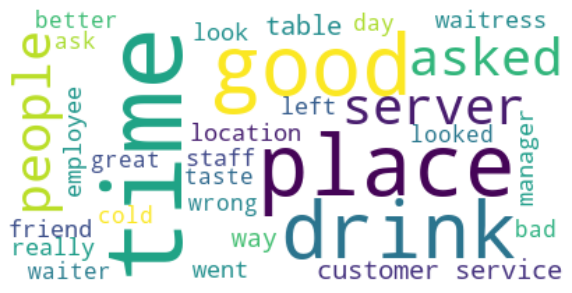

In [68]:
# wordcloud for star_1
cloud4 = WordCloud(stopwords=stopwords, background_color="white", max_words=30).generate(text_1)
plt.figure(figsize=(10,10))
plt.imshow(cloud4, interpolation ='bilinear')
plt.axis('off')
plt.show()

### Create Mask for word cloud for star rating 5

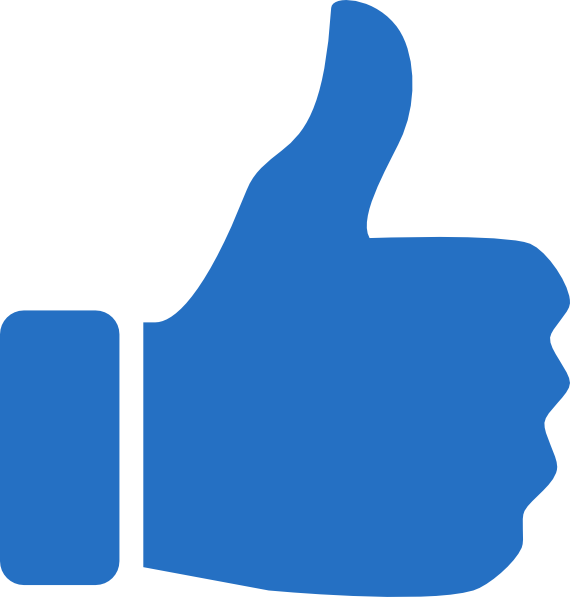

<Figure size 360x360 with 0 Axes>

In [6]:
# visualize mask for word cloud
Image.open('like.png')

In [82]:
#define like mask
like =np.array(Image.open('like.png'))
#check on numpy array whether all are 255
like

array([[[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       ...,

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255

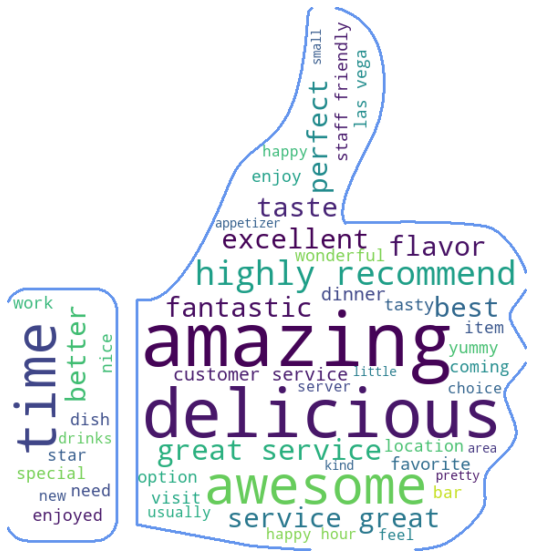

In [87]:
# wordcloud for star_5 with maske
cloud = WordCloud(stopwords=stopwords, background_color="white", max_words=50, mask=like, contour_width=3,
                 contour_color ='cornflowerblue').generate(text_5)
plt.figure(figsize=(20,10))
plt.imshow(cloud, interpolation ='bilinear')
plt.axis('off')
plt.show()

### Create Mask for word cloud for Star rating 1

In [7]:
dislike =np.array(Image.open('dislike2.png'))
dislike

array([[[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       ...,

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255

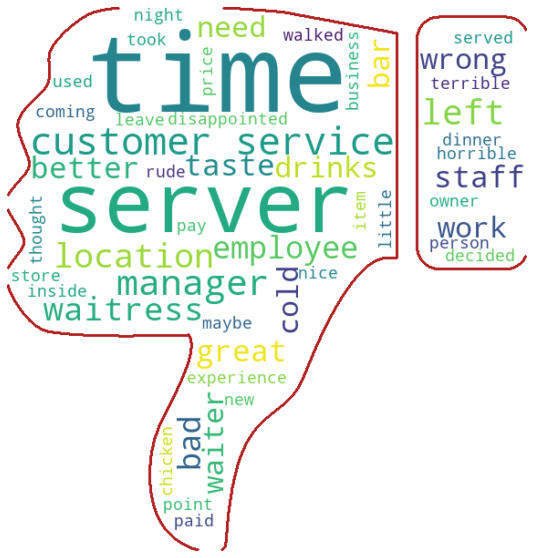

In [12]:
# wordcloud for star_1 with mask
cloud4 = WordCloud(stopwords=stopwords, background_color="white", max_words=50, mask = dislike, contour_width = 3,
                  contour_color ='firebrick').generate(text_1)
plt.figure(figsize = (20,10))
plt.imshow(cloud4, interpolation ='bilinear')
plt.axis('off')
plt.show()

From the above word clouds, we can see that the most common words for star 1 rating restaurants and star 5 rating restaurants are different. In star 5 rating restaurants, people are talking about the amazing, delicious food. But for star 1 rating restaurants, people are talking about bad service. So the service is the key to distiguish between good and bad restaurants. People will rate higher for the restaurants that have good or excellent service even through the food in those restaurants might not be that good. 

# Data Exploray Analysis

### Visulize the distribution of Negative Neutral Positive Distribution

In [184]:
#visulize the Negative Reviews with number of stars ratings

#subset the three sentiment to a df
sentiment = df[['positive', 'neutral','negative']]
display(sentiment.head())

#resahpe the sentiment to long form 
sentiment_long = pd.melt(sentiment, var_name = 'Sentiment Category', value_name='Sentiment Value')

#sanity check on the long form dataframe
display(sentiment_long[sentiment_long['Sentiment Category']=='positive'].head(5))
display(sentiment_long[sentiment_long['Sentiment Category']=='neutral'].head(5))
display(sentiment_long[sentiment_long['Sentiment Category']=='negative'].head(5))

,positive,neutral,negative
0,0.555,0.445,0.000
1,0.198,0.802,0.000
2,0.145,0.855,0.000
3,0.231,0.716,0.053
4,0.333,0.667,0.000


,Sentiment Category,Sentiment Value
0,positive,0.555
1,positive,0.198
2,positive,0.145
3,positive,0.231
4,positive,0.333


,Sentiment Category,Sentiment Value
2013544,neutral,0.445
2013545,neutral,0.802
2013546,neutral,0.855
2013547,neutral,0.716
2013548,neutral,0.667


,Sentiment Category,Sentiment Value
4027088,negative,0.000
4027089,negative,0.000
4027090,negative,0.000
4027091,negative,0.053
4027092,negative,0.000


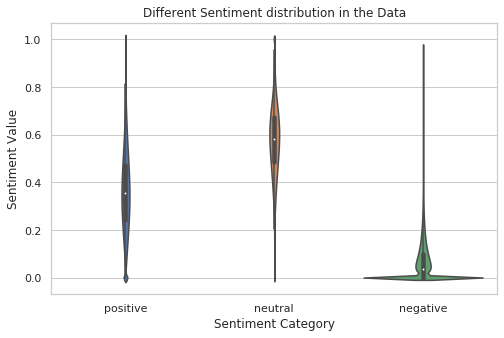

In [188]:
#Visualize the distribution for three category using violin plot
plt.figure(figsize=(8,5))
sns.set(style = 'whitegrid')
sns.violinplot(x ='Sentiment Category', y='Sentiment Value', data= sentiment_long)
plt.title('Different Sentiment distribution in the Data')
plt.xlabel('Sentiment Category')
plt.ylabel('Sentiment Value')
plt.show()

### Visulize the distribution of star reviews

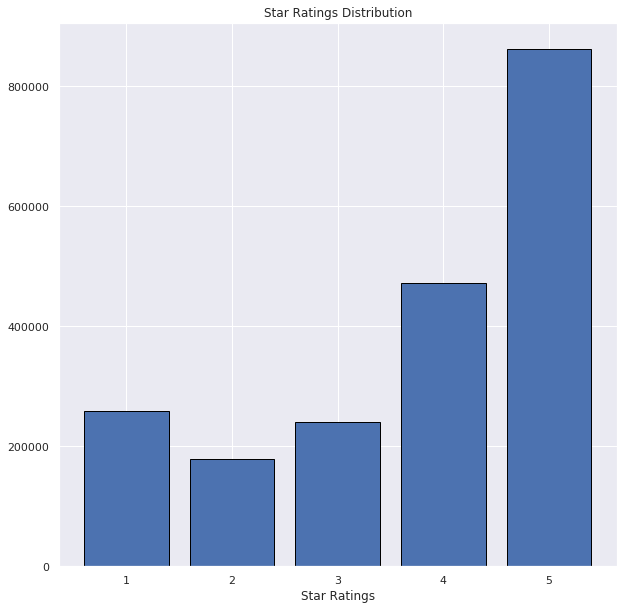

In [62]:
# visulize the star ratings count
sns.set(style = 'darkgrid')
plt.figure(figsize=(10,10))
plt.bar(df['star_individual'].value_counts().index,df['star_individual'].value_counts().values, edgecolor ='black')
plt.title('Star Ratings Distribution')
plt.xlabel('Star Ratings')
plt.show()

### Visulize the distribution of open and close restaurants

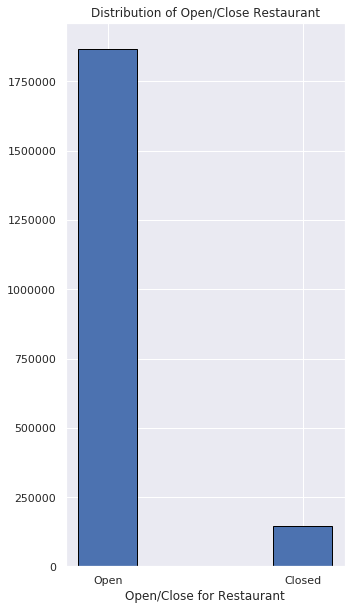

In [73]:
x_string = ['Open','Closed']
sns.set(style = 'darkgrid')
plt.figure(figsize=(5,10))
plt.bar(x_string, df['is_open'].value_counts().values, edgecolor='black', width=0.3)
plt.title('Distribution of Open/Close Restaurant')
plt.xlabel('Open/Close for Restaurant')
plt.show()

### Visulize number of star reviews for restaurant for restaurants closed vs opened

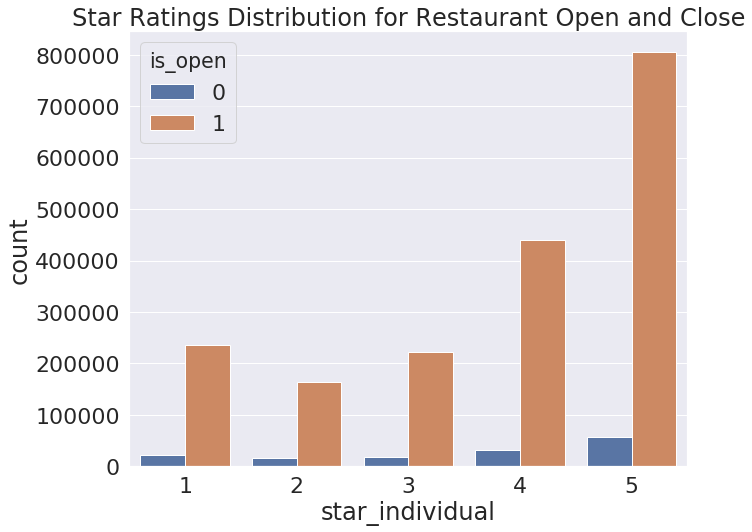

In [7]:
### Visulize star ratings for open and close

sns.set(font_scale=15)
sns.set(style = 'darkgrid')
plt.figure(figsize=(10,8))
sns.set(font_scale=2.0)
plt.title('Star Ratings Distribution for Restaurant Open and Close')
sns.countplot(x = 'star_individual', data=df, hue='is_open')
plt.show()

### Visulize the sentiment ratings distribution for star 1 and star 5 restaurants

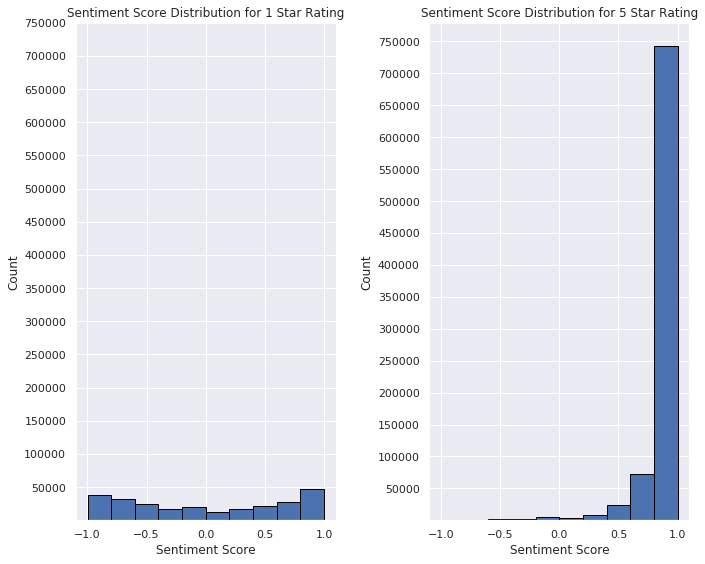

In [15]:
# visulize compound score distribution by star individual
y_range = np.arange(50000,800000,50000)
sns.set(font_scale=8)
sns.set(font_scale=1.0)
plt.subplots(1,2, figsize=(10,8))
plt.subplot(1,2,1)
plt.hist(star_1['compound_score'], edgecolor ='black')
plt.title('Sentiment Score Distribution for 1 Star Rating')
plt.yticks(y_range)
plt.xlabel('Sentiment Score')
plt.ylabel('Count')

plt.subplot(1,2,2)
plt.hist(star_5['compound_score'], edgecolor = 'black')
plt.title('Sentiment Score Distribution for 5 Star Rating')
plt.yticks(y_range)
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

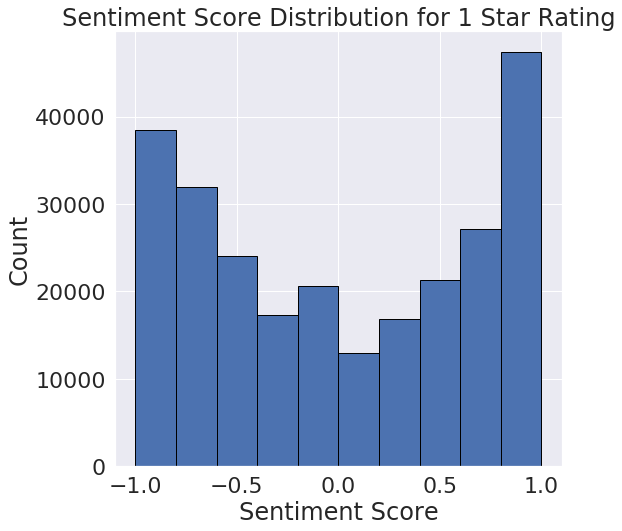

In [17]:
# change the scale of star rating 1 to distinguish more sentiment distribution
# visulize compound score distribution by star individual

sns.set(font_scale=15)
sns.set(font_scale=2.0)
plt.figure(figsize=(8,8))
plt.hist(star_1['compound_score'], edgecolor ='black')
plt.title('Sentiment Score Distribution for 1 Star Rating')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.show()

We can see that in the star 1 rating restaurants there are more negative sentiments compared to star 5 rating restaurants. Star 5 rating restaurants are mostly positive.

### Visualize the Sentiment Score Distribution Between Restaurant Open/Close

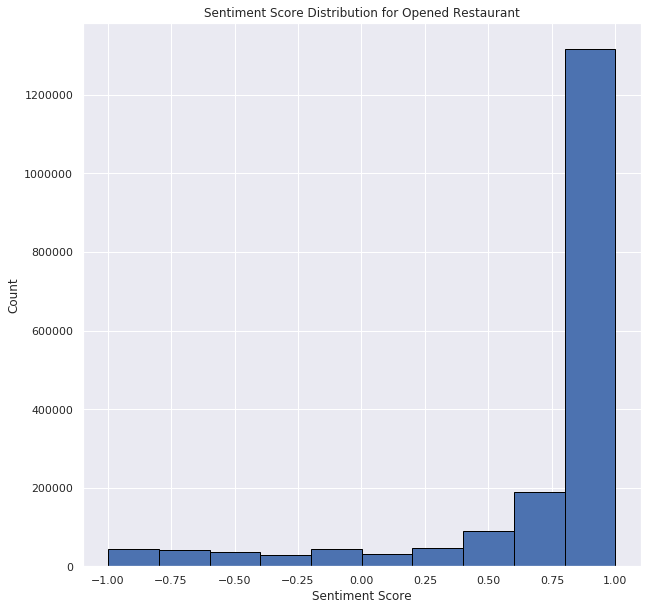

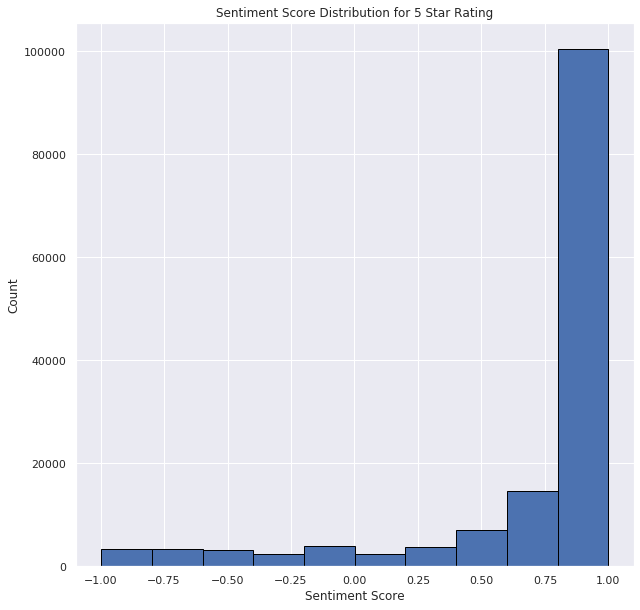

In [29]:
# Subset the open and close business
open_restaurant = df[df['is_open']==1]
close_restaurant = df[df['is_open']==0]

# visualize the compound score distribution for open restaurant
sns.set(font_scale=12)
sns.set(font_scale=1.0)
plt.figure(figsize=(10,10))
plt.hist(open_restaurant['compound_score'], edgecolor ='black')
plt.title('Sentiment Score Distribution for Opened Restaurant')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.show()

# visualize the compound score distribution for closed restaurant
plt.figure(figsize=(10,10))
plt.hist(close_restaurant['compound_score'], edgecolor = 'black')
plt.title('Sentiment Score Distribution for 5 Star Rating')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.show()

From the aboved sentiment distribution for open/closed restaurants, we can see that there is no clear distinguish of sentiment distribution betweeen the out of business restaurant vs the restaurants are still opened. 

# Train Test Split 

Before I start to modeling, it is important to split the dataset into the train and test. Since I will have two different prediction models, I will create y1 and y2. y1 is the star ratings predictions from the review comments. y2 is binary class prediction on whether the business will continue based on the review comments. In addition, I found the y1 and y2 are both imbalance in terms of class distribution. Therefore, I utlized the oversampling method to make sure bothe y1 and y2 are balanced. 

Steps completed

1. Setting up X and y. Two different y. y1 = business_stars, y2=is_open
2. Train test split
3. Oversampling for both y1 and y2

In [3]:
# Setting up X and y1  - Using sentiment and other numeric data to get business_stars

#X combine cleaned_text with numeric data

X = df[['polarity', 'subjectivity', 'review_length', \
       'negative', 'neutral', 'positive', 'compound_score','review_count','num_checkins']]

#y1 is the stars ratings for each reviewer
y1 = df['star_individual']


# y2 is whether the business is still open
y2 = df['is_open']

In [4]:
#sanity check for y1
display(X.shape)
display(y1.shape)

(2013544, 9)

(2013544,)

In [5]:
# Check on y1 for number of different classes
y1.value_counts()
#y1 has imbalance between each ratings

5    862727
4    472769
1    258261
3    240588
2    179199
Name: star_individual, dtype: int64

In [6]:
# Check on y2 for number of different classes
y2.value_counts()

# y2 has imbalance between open and close

1    1868662
0     144882
Name: is_open, dtype: int64

In [7]:
#Over sampling to make the imbanced class balanced
from imblearn.over_sampling import SMOTE
smote = SMOTE()

X_resampled, y_resampled = smote.fit_resample(X,y1)
X_resampled_2, y_resampled_2 =smote.fit_resample(X,y2)

In [8]:
#Sanity check y1 after oversampling
display(X_resampled.shape)
display(y_resampled.shape)

#Sanity check y2 after oversampling
display(X_resampled_2.shape)
display(y_resampled_2.shape)

(4313635, 9)

(4313635,)

(3737324, 9)

(3737324,)

In [9]:
a =  pd.DataFrame(y_resampled)
a.columns=['y1']
display(a.y1.value_counts())


5    862727
4    862727
3    862727
2    862727
1    862727
Name: y1, dtype: int64

In [32]:
#Display the result after oversampling and replace y2 with oversampling results
b = pd.DataFrame(y_resampled_2)
b.columns=['y2']
display(b.y2.value_counts())


1    1868662
0    1868662
Name: y2, dtype: int64

##  Combination X -y1 numeric with star ratings

In [9]:
# split the X1- y1 data into train_test split set up test_size to be 0.3
from sklearn.model_selection import train_test_split
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_resampled, y_resampled, test_size=0.3,\
                                                            random_state=15, stratify = y_resampled)

## Combination X -y2 numeric data with business continuity

In [10]:
# split the X1- y2 data into train_test split set up test_size to be 0.3
from sklearn.model_selection import train_test_split
X_train_con, X_test_con, y_train_con, y_test_con = train_test_split(X_resampled_2, y_resampled_2 ,\
                                                                    test_size=0.3, random_state=15, stratify = y_resampled_2)

#  Modeling - Star Rating y1

In this section, I will use all numeric features I developed from the feature engineering section to predict the individual rates. 

First I will simply run a Logistic Regression, Random Forest, SVM (linear), SVM (Non-linear), Xgboost without changing any hyperparameters. Also I will apply a PCA dimention reduction and run a second logistic regression to see whether the accuracy rate increase. 

Second, I will pick top three models with highes accuracy (Logistic Regression without PCA, Random Forest, and Xgboost) and tunning the hyperparameter for each of the models. 

Finnally, after determined the hyperparameters for each of the three models, I will evaluate the model accuracy, and confusion matrix and pick the best model. 

Steps: 
1. Run Logistic Regression, RandomForest, SVM (linear), SVM, Xgboost without tuning any hyperparameter
2. Apply PCA, run the logistic regression again. Compare the accuracy
3. Optimize Logistic Regression, RandomForest, and Xgboost by tuning hyperparameter. 

#### First Logistic Regression

In [17]:
#Logistic regression with Numeric data and star ratings 
from sklearn.linear_model import LogisticRegression
log_num = LogisticRegression(solver='lbfgs').fit(X_train_1,y_train_1)

print(f'Train Data Score for Log with X1-y1: {log_num.score(X_train_1, y_train_1)}')
print(f'Test Data Score for Log with X1-y1: {log_num.score(X_test_1, y_test_1)}')


Train Data Score for Log with X1-y1: 0.43670004477497265
Test Data Score for Log with X1-y1: 0.4372513215840308


In [18]:
#Apply PCA with Logistic Regression
from sklearn.decomposition import PCA

#Apply pca without specify the number of component first
my_pca = PCA().fit(X_train_1) 

#Transform the data
X_train_1_pca = my_pca.transform(X_train_1) 
X_test_1_pca = my_pca.transform(X_test_1)

#Logistic regression with Numeric data and star ratings after PCA
from sklearn.linear_model import LogisticRegression
log_num_pca = LogisticRegression(solver='lbfgs').fit(X_train_1_pca,y_train_1)

print(f'Train Data Score for Log w/PCA X1-y1: {log_num_pca.score(X_train_1_pca, y_train_1)}')
print(f'Test Data Score for Log w/PCA X1-y1: {log_num_pca.score(X_test_1_pca, y_test_1)}')


Train Data Score for Log w/PCA X1-y1: 0.4368298657015761
Test Data Score for Log w/PCA X1-y1: 0.4371810019542675


Since the accuracy after PCA did not clearly improved than before the accuracy of PCA, therefore, not using PCA reduction before any models. 

#### First RandomForest

In [6]:
#Random Forest with Numeric data and star ratings 
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier().fit(X_train_1,y_train_1)

print(f'Train Data Score for RF with X1-y1: {rf_model.score(X_train_1, y_train_1)}')
print(f'Test Data Score for RF with X1-y1: {rf_model.score(X_test_1, y_test_1)}')


Train Data Score for RF with X1-y1: 0.9865886709992338
Test Data Score for RF with X1-y1: 0.48112617206123853


#### First LinearSVC

In [71]:
#SVM with numeric data and star ratings 
from sklearn.svm import LinearSVC

svm_model = LinearSVC().fit(X_train_1,y_train_1)

print(f'Train Data Score for RF with X1-y1: {svm_model.score(X_train_1, y_train_1)}')
print(f'Test Data Score for RF with X1-y1: {svm_model.score(X_test_1, y_test_1)}')

Train Data Score for RF with X1-y1: 0.44673851349433835
Test Data Score for RF with X1-y1: 0.4461778884356625


#### First SVM

In [ ]:
#SVM with numeric data and star ratings 
from sklearn.svm import SVC

svc_model = SVC().fit(X_train_1,y_train_1)

print(f'Train Data Score for RF with X1-y1: {svc_model.score(X_train_1, y_train_1)}')
print(f'Test Data Score for RF with X1-y1: {svc_modebbl.score(X_test_1, y_test_1)}')

#### First XGBoost

In [5]:
#XGBoost with numeric data and star ratings
from xgboost import XGBClassifier
xgb_model = XGBClassifier(n_jobs = -1).fit(X_train_1, y_train_1)

print(f'Train Data Score for XGboost with X1-y1: {xgb_model.score(X_train_1, y_train_1)}')
print(f'Test Data Score for XGboost with X1-y1: {xgb_model.score(X_test_1, y_test_1)}')

Train Data Score for XGboost with X1-y1: 0.5293661492181514
Test Data Score for XGboost with X1-y1: 0.5298345870636224


#### Optimize Logistic Regress by Tunning out Hyperparameter c

In [11]:
#import packages
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 0.0001 0.001 0.01 0.1 1 10 100 1000 10000 100000 1000000 10000000 100000000 1000000000 

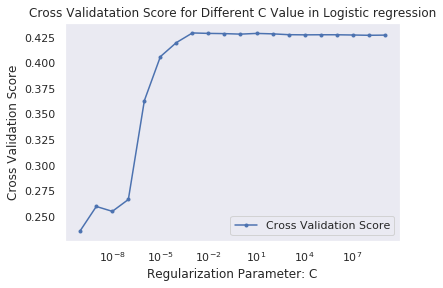

In [113]:
# setting up c value for logistic regression
log_c = list(map(lambda x: 10**x, range(-10,10)))

cv_score =[]
for c in log_c:
    print(c, end= ' ')
    log_num2 = LogisticRegression(C=c, solver = 'lbfgs', n_jobs=-1)
    
    avg_score = np.mean(cross_val_score(log_num2, X_train_1, y_train_1, cv=5))
    
    cv_score.append(avg_score)


#Plot out the result
sns.set(style = 'white')
plt.figure()
plt.plot(log_c, cv_score, label="Cross Validation Score",marker='.')
plt.legend()
plt.title('Cross Validatation Score for Different C Value in Logistic regression')
plt.xscale("log")
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Cross Validation Score')
plt.grid()
plt.show()

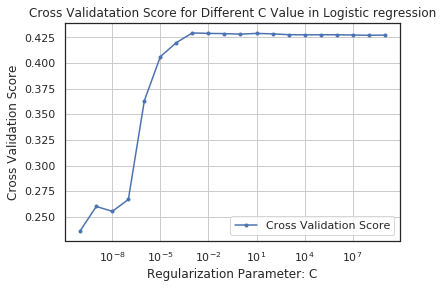

In [115]:
# change the plot background to white
sns.set(style = 'white')
plt.figure()
plt.plot(log_c, cv_score, label="Cross Validation Score",marker='.')
plt.legend()
plt.title('Cross Validatation Score for Different C Value in Logistic regression')
plt.xscale("log")
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Cross Validation Score')
plt.grid()
plt.show()

Based on above hyperparameter optimization for c value in logistic regression, when c= 1e(-3) the accuracy seems to have the highest. Therefore, the logsitc regression will choose c= 1e(-3)  

#### Optimize Random Forest by Tunning out Hyperparameter max_depth

In [49]:
# setting up number_estimator for logistic regression
n_depth = np.arange(1,41,1)

cv_score_rf = []
from sklearn.ensemble import RandomForestClassifier
for d in n_depth:
    print(d, end= ' ')
    rf_model_2 = RandomForestClassifier(max_depth= d, n_jobs=-1,)
    avg_score1 = np.mean(cross_val_score(rf_model_2, X_train_1, y_train_1, cv=3))
    
    cv_score_rf.append(avg_score1)
    

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 

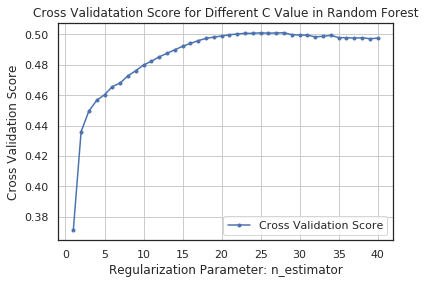

In [50]:
#Plot out the result
sns.set(style = 'white')
plt.figure()
plt.plot(n_depth, cv_score_rf, label="Cross Validation Score",marker='.')
plt.legend()
plt.title('Cross Validatation Score for Different C Value in Random Forest')
plt.xlabel('Regularization Parameter: max_depth')
plt.ylabel('Cross Validation Score')
plt.grid()
plt.show()

Based on above hyperparameter optimization for max_depth in Random Forest, when number of trees equal to 20 the accuracy seems to have the highest. Therefore, for the Random Forest the max_depth for each tree will be equal to 20.  

#### Optimize Xgboost by Tunning out Hyperparameter n

In [18]:
# setting up number_estimator for logistic regression
log_c = list(map(lambda x: 10**x, range(-10,10)))

cv_score_xg = []
from xgboost import XGBClassifier
for l in log_c:
    
    xgb_model_2 = XGBClassifier(learning_rate=l, n_jobs=-1)
    avg_score2 = np.mean(cross_val_score(xgb_model_2, X_train_1, y_train_1, cv=3))
    
    cv_score_xg.append(avg_score2)
    
    print(l, end=' ')

1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 0.0001 0.001 0.01 0.1 1 10 100 1000 10000 100000 1000000 10000000 100000000 1000000000 

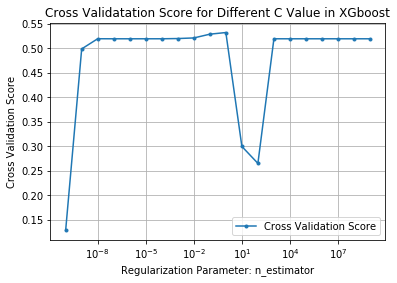

In [21]:
#Plot out the result
plt.figure()
plt.plot(log_c, cv_score_xg, label="Cross Validation Score",marker='.')
plt.legend()
plt.title('Cross Validatation Score for Different C Value in XGboost')
plt.xlabel('Regularization Parameter: n_estimator')
plt.xscale('log')
plt.ylabel('Cross Validation Score')
plt.grid()
plt.show()

Based on above hyperparameter optimization for learning rate in XGboost, when the learning rate equals to 10e(0) the accuracy seems to have the highest. Therefore, for the XGboost the learning rate will be equal to 1.  

#### Final Logistic Regression Model

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
log_num_final = LogisticRegression(solver='lbfgs', C=10**(-3), n_jobs=-1).fit(X_train_1,y_train_1)

print(f'Train Data Score for final Logistic model with X1-y1: {log_num_final.score(X_train_1, y_train_1)}')
print(f'Test Data Score for final Logistic model with X1-y1: {log_num_final.score(X_test_1, y_test_1)}')


#print out classification report 
y_pred_log_num_final = log_num_final.predict(X_test_1)
print(classification_report(y_test_1, y_pred_log_num_final))


Train Data Score for final Logistic model with X1-y1: 0.433207464438339
Test Data Score for final Logistic model with X1-y1: 0.4336449291433137
              precision    recall  f1-score   support

           1       0.60      0.62      0.61    258819
           2       0.38      0.26      0.31    258818
           3       0.33      0.42      0.37    258818
           4       0.36      0.15      0.21    258818
           5       0.45      0.71      0.55    258818

    accuracy                           0.43   1294091
   macro avg       0.42      0.43      0.41   1294091
weighted avg       0.42      0.43      0.41   1294091



#### Final Random Forest Model

In [13]:
# Random Forest with 400 of decision trees. 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
rf_model_final = RandomForestClassifier(n_jobs=-1, max_depth = 20).fit(X_train_1, y_train_1)

print(f'Train Data Score for final Random Forest model with X1-y1: {rf_model_final.score(X_train_1, y_train_1)}')
print(f'Test Data Score for final Random Forest model with X1-y1: {rf_model_final.score(X_test_1, y_test_1)}')

#print out classification report 
y_pred_rf_num_final = rf_model_final.predict(X_test_1)
print(classification_report(y_test_1,y_pred_rf_num_final))


Train Data Score for final Random Forest model with X1-y1: 0.6966296897809735
Test Data Score for final Random Forest model with X1-y1: 0.508470424413739
              precision    recall  f1-score   support

           1       0.64      0.67      0.65    258819
           2       0.44      0.44      0.44    258818
           3       0.41      0.40      0.40    258818
           4       0.43      0.37      0.40    258818
           5       0.60      0.66      0.63    258818

    accuracy                           0.51   1294091
   macro avg       0.50      0.51      0.50   1294091
weighted avg       0.50      0.51      0.50   1294091



#### Final Xgboost Model

In [14]:
from xgboost import XGBClassifier
xgb_model_final = XGBClassifier(learning_rate=1, n_jobs=-1).fit(X_train_1, y_train_1)

print(f'Train Data Score for final Xgboost model with X1-y1: {xgb_model_final.score(X_train_1, y_train_1)}')
print(f'Test Data Score for final Xgboost model with X1-y1: {xgb_model_final.score(X_test_1, y_test_1)}')

#print out classification report 
y_pred_xgb_num_final = xgb_model_final.predict(X_test_1)
print(classification_report(y_test_1,y_pred_xgb_num_final))


Train Data Score for final Xgboost model with X1-y1: 0.5069242243199635
Test Data Score for final Xgboost model with X1-y1: 0.5049583066414959
              precision    recall  f1-score   support

           1       0.62      0.67      0.64    258819
           2       0.41      0.41      0.41    258818
           3       0.39      0.38      0.39    258818
           4       0.45      0.35      0.40    258818
           5       0.61      0.71      0.65    258818

    accuracy                           0.50   1294091
   macro avg       0.50      0.50      0.50   1294091
weighted avg       0.50      0.50      0.50   1294091



## Model Evaluation: Star Rating y1

Based on above resutls. The Random Forest has the highest accuracy in prediction. Therefore, Random Forest will be the final model to predict different star ratings. From the confusion matrix of the Random Forest model, we can see that both precision and recall for detect star 1 and star 5 ratings are above 60%. However, the precision and recall for other class are not so well. Mainly because the sentiment can not be clearly distinguish amoung rating of 2,3 and 4. Maybe in the future, it would worth to try using Bag-of-words or TDIDF model to distinguish rating 2, 3, and 4. 

#  Modeling - Business continuity y2

## Business Continuity y2

In this section, I will use all numeric features I developed from the feature engineering section to predict the business continuity.

First I will simply run Logistic Regression, Random Forest, Xgboost without changing any hyperparameters. 

Second, I will tune the hyperparmeters for the sklearn Logistic Regression, Random Forest, Xgboost with cross validation in the training data.

Finnally, after determined the hyperparameters for each of the three models, I will evaluate the model accuracy, and confusion matrix and pick the best model. 


#### First Logistic Regression without Tunning

In [154]:
# Logistic Regression with numeric data and business continuity
from sklearn.linear_model import LogisticRegression
log_num2 = LogisticRegression().fit(X_train_con,y_train_con)

#get the accuracy score
print(f'Train Data Score for Log with X1-y2: {log_num2.score(X_train_con, y_train_con)}')
print(f'Test Data Score for Log with X1-y2: {log_num2.score(X_test_con, y_test_con)}')


Train Data Score for Log with X1-y2: 0.5596641751964546
Test Data Score for Log with X1-y2: 0.5589583641783165


In [155]:
# Confusion Matrix for logistic regression
from sklearn.metrics import classification_report

y_pred_log_num2 = log_num2.predict(X_test_con)
print(classification_report(y_test_con, y_pred_log_num2))

              precision    recall  f1-score   support

           0       0.54      0.79      0.64    560599
           1       0.61      0.33      0.42    560599

    accuracy                           0.56   1121198
   macro avg       0.58      0.56      0.53   1121198
weighted avg       0.58      0.56      0.53   1121198



#### First Random Forest without Tunning

In [80]:
#Random Forest with Numeric data and continuity 
from sklearn.ensemble import RandomForestClassifier

rf_model_con = RandomForestClassifier().fit(X_train_con, y_train_con)

print(f'Train Data Score for RF with X1-y1: {rf_model_con.score(X_train_con, y_train_con)}')
print(f'Test Data Score for RF with X1-y1: {rf_model_con.score(X_test_con, y_test_con)}')


# Get the prediction value for rf_model_con
y_pred_rf = rf_model_con.predict(X_test_con)

#print confusion matrix
print(classification_report(y_test_con, y_pred_rf))

Train Data Score for RF with X1-y1: 0.9964271598539214
Test Data Score for RF with X1-y1: 0.8902272390782002
              precision    recall  f1-score   support

           0       0.86      0.93      0.89    560599
           1       0.93      0.85      0.89    560599

    accuracy                           0.89   1121198
   macro avg       0.89      0.89      0.89   1121198
weighted avg       0.89      0.89      0.89   1121198



#### First XGboost without Tunning

In [81]:
#XGBoost with numeric data and continuity
from xgboost import XGBClassifier
xgb_model_con = XGBClassifier(n_jobs = -1).fit(X_train_con, y_train_con)

print(f'Train Data Score for XGboost with X1-y2: {xgb_model_con.score(X_train_con, y_train_con)}')
print(f'Test Data Score for XGboost with X1-y2: {xgb_model_con.score(X_test_con, y_test_con)}')

# Get the prediction value for rf_model_con
y_pred_xg = xgb_model_con.predict(X_test_con)

#print confusion matrix
print(classification_report(y_test_con, y_pred_xg))


Train Data Score for XGboost with X1-y2: 0.7064590925666424
Test Data Score for XGboost with X1-y2: 0.7060492437553403
              precision    recall  f1-score   support

           0       0.69      0.75      0.72    560599
           1       0.73      0.66      0.69    560599

    accuracy                           0.71   1121198
   macro avg       0.71      0.71      0.71   1121198
weighted avg       0.71      0.71      0.71   1121198



#### Logistic Regression Tunning C value

In [156]:
#import packages
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [157]:
# setting up c value for logistic regression
log_c = list(map(lambda x: 10**x, range(-10,10)))

cv_score_con =[]
for c in log_c:
    
    log_con1 = LogisticRegression(C=c, solver = 'lbfgs',n_jobs=-1)
    
    avg_score1 = np.mean(cross_val_score(log_con1, X_train_con,y_train_con, cv=3))
    
    cv_score_con.append(avg_score1)
    
    print(c, end= ' ')
    
print(cv_score_con)    
    

1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 0.0001 0.001 0.01 0.1 1 10 100 1000 10000 100000 1000000 10000000 100000000 1000000000 [0.5638126756891678, 0.5605551873266044, 0.5601920549698294, 0.5597268633085716, 0.5596878743607915, 0.5596890210945498, 0.5596894033391359, 0.559690167828308, 0.559690167828308, 0.559690167828308, 0.559690167828308, 0.559690167828308, 0.559690167828308, 0.559690167828308, 0.559690167828308, 0.559690167828308, 0.559690167828308, 0.559690167828308, 0.559690167828308, 0.559690167828308]


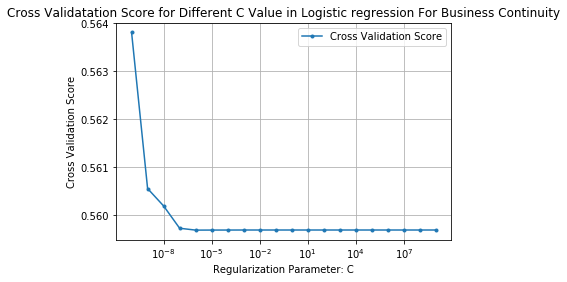

In [158]:
#Plot out the result
plt.figure()
plt.plot(log_c, cv_score_con, label="Cross Validation Score",marker='.')
plt.legend()
plt.title('Cross Validatation Score for Different C Value in Logistic regression For Business Continuity')
plt.xscale("log")
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Cross Validation Score')
plt.grid()
plt.show()

#### Random Forest Tunning number of trees

In [53]:
# setting up number_estimator for Random Forest
n_depth = np.arange(1,51,1)

cv_score_con_rf = []
from sklearn.ensemble import RandomForestClassifier
for d in n_depth:
    
    rf_model_con1 = RandomForestClassifier(n_jobs=-1, max_depth=d)
    avg_score_con = np.mean(cross_val_score(rf_model_con1, X_train_con, y_train_con, cv=3))
    
    cv_score_con_rf.append(avg_score_con)

    print(d, end= ' ')


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

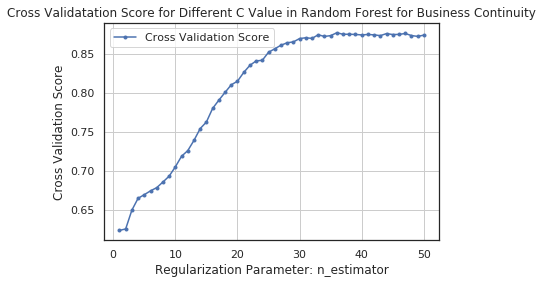

In [54]:
#Plot out the result
plt.figure()
plt.plot(n_depth, cv_score_con_rf, label="Cross Validation Score",marker='.')
plt.legend()
plt.title('Cross Validatation Score for Different C Value in Random Forest for Business Continuity')
plt.xlabel('Regularization Parameter: n_estimator')
plt.ylabel('Cross Validation Score')
plt.grid()
plt.show()

#### XGboost tunning learning rate

In [161]:
# setting up number_estimator for XGboost
log_c = list(map(lambda x: 10**x, range(-10,2)))

cv_score_con_xg = []
from xgboost import XGBClassifier
for l in log_c:
    
    xgb_model_con1 = XGBClassifier(learning_rate=l, n_jobs=-1)
    avg_score_con1 = np.mean(cross_val_score(xgb_model_con1, X_train_con, y_train_con, cv=3))
    
    cv_score_con_xg.append(avg_score_con1)
    
    print(l, end=' ')
    
    
   

1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 0.0001 0.001 0.01 0.1 1 10 

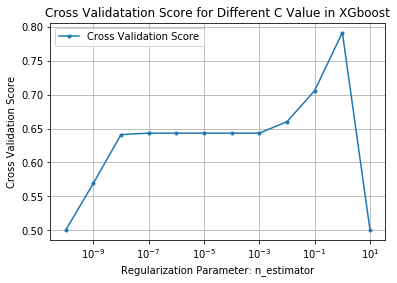

In [163]:
#Plot out the result
plt.figure()
plt.plot(log_c, cv_score_con_xg, label="Cross Validation Score",marker='.')
plt.legend()
plt.title('Cross Validatation Score for Different C Value in XGboost')
plt.xlabel('Regularization Parameter: n_estimator')
plt.xscale('log')
plt.ylabel('Cross Validation Score')
plt.grid()
plt.show()

#### Final Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
log_con_final = LogisticRegression(C=10**(-10)).fit(X_train_con,y_train_con)

#get the accuracy score
print(f'Train Data Score for final Log with X1-y2: {log_con_final.score(X_train_con, y_train_con)}')
print(f'Test Data Score for final Log with X1-y2: {log_con_final.score(X_test_con, y_test_con)}')

#print confusion matrix for Final Logistic Regression
y_pred_log_con = log_con_final.predict(X_test_con)
print(classification_report(y_test_con, y_pred_log_con))

Train Data Score for final Log with X1-y2: 0.5658603599367921
Test Data Score for final Log with X1-y2: 0.5649519531786535
              precision    recall  f1-score   support

           0       0.56      0.63      0.59    560599
           1       0.58      0.50      0.53    560599

    accuracy                           0.56   1121198
   macro avg       0.57      0.56      0.56   1121198
weighted avg       0.57      0.56      0.56   1121198



#### Final Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
rf_model_con_final = RandomForestClassifier(n_jobs=-1, max_depth=33).fit(X_train_con, y_train_con)

#get the accuracy score
print(f'Train Data Score for final RF with X1-y2: {rf_model_con_final.score(X_train_con, y_train_con)}')
print(f'Test Data Score for final RF with X1-y2: {rf_model_con_final.score(X_test_con, y_test_con)}')

#print confusion matrix for Final Logistic Regression
y_pred_rf_con = rf_model_con_final.predict(X_test_con)
print(classification_report(y_test_con, y_pred_rf_con))

Train Data Score for final RF with X1-y2: 0.9818051577026489
Test Data Score for final RF with X1-y2: 0.8885112174656038
              precision    recall  f1-score   support

           0       0.87      0.92      0.89    560599
           1       0.91      0.86      0.89    560599

    accuracy                           0.89   1121198
   macro avg       0.89      0.89      0.89   1121198
weighted avg       0.89      0.89      0.89   1121198



#### Final Xgboost

In [17]:
from xgboost import XGBClassifier
xgb_model_con_final = XGBClassifier(learning_rate=1, n_jobs=-1).fit(X_train_con, y_train_con)

#get the accuracy score
print(f'Train Data Score for final Xgboost with X1-y2: {xgb_model_con_final.score(X_train_con, y_train_con)}')
print(f'Test Data Score for final Xgboost with X1-y2: {xgb_model_con_final.score(X_test_con, y_test_con)}')

#print confusion matrix for Final Logistic Regression
y_pred_xgb_con = xgb_model_con_final.predict(X_test_con)
print(classification_report(y_test_con, y_pred_xgb_con))
    

Train Data Score for final Xgboost with X1-y2: 0.8311289288054169
Test Data Score for final Xgboost with X1-y2: 0.8304385130904621
              precision    recall  f1-score   support

           0       0.83      0.82      0.83    560599
           1       0.83      0.84      0.83    560599

    accuracy                           0.83   1121198
   macro avg       0.83      0.83      0.83   1121198
weighted avg       0.83      0.83      0.83   1121198



## Model Evaluation - y2

### ROC Curve and AUC Score

In [21]:
# plot out roc
from sklearn.metrics import roc_curve, roc_auc_score

#get the probability of the X_test_con prediction for all three models
y_proba_log_con = log_con_final.predict_proba(X_test_con)[:,1]
y_proba_rf_con = rf_model_con_final.predict_proba(X_test_con)[:,1]
y_proba_xg_con = xgb_model_con_final.predict_proba(X_test_con)[:,1]

#roc metrics for log
fprs_log, tprs_log, thresholds_log = roc_curve(y_test_con, y_proba_log_con)
roc_auc_log = roc_auc_score(y_test_con, y_proba_log_con)

#roc metrics for random forest
fprs_rf, tprs_rf, thresholds_rf = roc_curve(y_test_con, y_proba_rf_con)
roc_auc_rf = roc_auc_score(y_test_con, y_proba_rf_con)

#roc metrics for xgboost
fprs_xg, tprs_xg, thresholds_xg = roc_curve(y_test_con, y_proba_xg_con)
roc_auc_xg = roc_auc_score(y_test_con, y_proba_xg_con)

Area under curve (AUC) Random Forest:0.9592494206696739
Area under curve (AUC) XGboost:0.9217849696689401
Area under curve (AUC) Logistic:0.5614488532920708


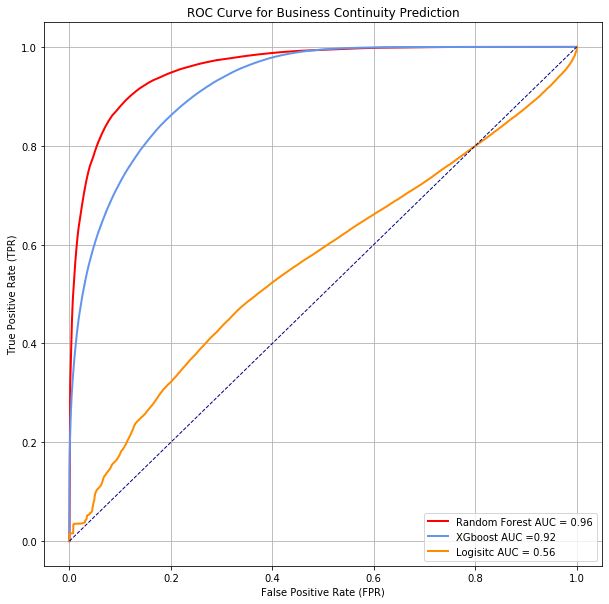

In [29]:
#plot the result for Logistic, Random Forest, and XgBoost

#print out the result
print(f'Area under curve (AUC) Random Forest:{roc_auc_rf}')
print(f'Area under curve (AUC) XGboost:{roc_auc_xg}')
print(f'Area under curve (AUC) Logistic:{roc_auc_log}')

plt.figure(figsize=(10,10))
plt.plot(fprs_rf, tprs_rf, color='red',
        lw = 2, label ='Random Forest AUC = %0.2f'% roc_auc_rf)
plt.plot(fprs_xg, tprs_xg, color='cornflowerblue',
        lw = 2, label ='XGboost AUC =%0.2f'% roc_auc_xg)
plt.plot(fprs_log, tprs_log, color='darkorange',
         lw=2, label='Logisitc AUC = %0.2f' % roc_auc_log)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Business Continuity Prediction')
plt.legend(loc="best")
plt.grid()
plt.show()




### Model Evaluation: Business Continuity y2

Based on above resutls. The Random Forest has the highest accuracy in prediction for the two class (open or closed). Therefore, Random Forest will be the final model to predict different star ratings. From the confusion matrix of the Random Forest model and the ROC curve, we can see that Random Forest is a very good model to predict whether the restaurants are opened or closed solely based on the sentiment of the review texts. The models performs very well after the oversampling adjustment. 

However, using sentiment to predict whether the restaurants are continued open or out of business is very limit and assume other factors do not change. The restaurants continiuty depends on a lot of other factors. I am hoping the sentiment analysis to predict the business continuity can be used to evaluate the potential goodwill of the restaurants in addition to other financial evaluation. 

# The Next Step

The next step for the Yelp Sentiment Analysis would be to develope more robost machine learning models to distinguish the star rating of 2, 3, and 4. With additional machine learning models and combination  of UX design and Web development, I hope I can developed a robust website product to provide service to different restaruants owners who want to improve their overall business ratings on Yelp. Hence improve the overall reputation of the restaurants. 